## Feature Engineering for Short Video Recommender System

This notebook performs feature engineering on the KuaiRec dataset to prepare it for a short video recommender system.

### Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from tqdm import tqdm
import os
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

In [2]:
DATA_PATH = 'data_final_project/KuaiRec 2.0/data/'

train_data = pd.read_csv(f'{DATA_PATH}big_matrix.csv')
test_data = pd.read_csv(f'{DATA_PATH}small_matrix.csv')

item_categories = pd.read_csv(f"{DATA_PATH}item_categories.csv")
item_daily_features = pd.read_csv(f"{DATA_PATH}item_daily_features.csv")
social_network = pd.read_csv(f"{DATA_PATH}social_network.csv")
user_features = pd.read_csv(f"{DATA_PATH}user_features.csv")
kuairec_caption = pd.read_csv(f"{DATA_PATH}kuairec_caption_category.csv", 
                             engine="python", sep=",", quotechar='"', on_bad_lines='skip')

# Clean video IDs in caption data
kuairec_caption = kuairec_caption[pd.to_numeric(kuairec_caption['video_id'], errors='coerce').notna()]
kuairec_caption['video_id'] = kuairec_caption['video_id'].astype(int)

print(f"Datasets loaded successfully.")
print(f"Train data shape: {train_data.shape}")
print(f"Number of unique users: {train_data['user_id'].nunique()}")
print(f"Number of unique videos: {train_data['video_id'].nunique()}")
print(f"Number of unique video IDs in captions data: {kuairec_caption['video_id'].nunique()}")


Datasets loaded successfully.
Train data shape: (12530806, 8)
Number of unique users: 7176
Number of unique videos: 10728
Number of unique video IDs in captions data: 10728


In [3]:
# Process watch_ratio - clamp extreme values to keep them in a reasonable range
# Normally, a watch_ratio > 1 can indicate replays, but we clamp to 2.0 as a reasonable max
train_data['watch_ratio_clamped'] = np.clip(train_data['watch_ratio'], 0, 2.0)
test_data['watch_ratio_clamped'] = np.clip(test_data['watch_ratio'], 0, 2.0)

# Create a binary indicator of user interest based on watch ratio
# We consider watch_ratio >= 0.8 as a positive interaction (user was interested in the video)
POSITIVE_THRESHOLD = 0.8
train_data['positive_interaction'] = (train_data['watch_ratio_clamped'] >= POSITIVE_THRESHOLD).astype(int)
test_data['positive_interaction'] = (test_data['watch_ratio_clamped'] >= POSITIVE_THRESHOLD).astype(int)

print(f"Positive interactions in train set: {train_data['positive_interaction'].sum()} / {len(train_data)} ({train_data['positive_interaction'].mean()*100:.2f}%)")
print(f"Positive interactions in test set: {test_data['positive_interaction'].sum()} / {len(test_data)} ({test_data['positive_interaction'].mean()*100:.2f}%)")


Positive interactions in train set: 5683062 / 12530806 (45.35%)
Positive interactions in test set: 2218724 / 4676570 (47.44%)


### Creation of User Features


In [4]:
print("Creating user features...")

# Average viewing behavior per user
user_behavior = train_data.groupby('user_id').agg({
    'watch_ratio': ['mean', 'std', 'count'],
    'play_duration': ['mean', 'sum'],
    'positive_interaction': 'sum'
}).reset_index()

user_behavior.columns = ['user_id', 'avg_watch_ratio', 'std_watch_ratio', 'interaction_count', 
                        'avg_play_duration', 'total_play_duration', 'positive_interactions']

# Video duration preference per user
user_duration_pref = train_data.groupby('user_id')['video_duration'].agg(['mean', 'std']).reset_index()
user_duration_pref.columns = ['user_id', 'preferred_video_duration', 'video_duration_std']

user_features_subset = user_features[['user_id', 'user_active_degree', 'follow_user_num', 
                                     'fans_user_num', 'friend_user_num', 'register_days']]

user_features_enriched = user_behavior.merge(user_duration_pref, on='user_id', how='left')
user_features_enriched = user_features_enriched.merge(user_features_subset, on='user_id', how='left')

user_features_enriched = user_features_enriched.fillna(0)

print(f"Created user features for {len(user_features_enriched)} users with {len(user_features_enriched.columns) - 1} features each.")
display(user_features_enriched.head())

Creating user features...
Created user features for 7176 users with 13 features each.


,user_id,avg_watch_ratio,std_watch_ratio,interaction_count,avg_play_duration,total_play_duration,positive_interactions,preferred_video_duration,video_duration_std,user_active_degree,follow_user_num,fans_user_num,friend_user_num,register_days
0,0,1.135499,3.841481,2513,10262.175885,25788848,1360,12932.512137,16305.974867,high_active,5,0,0,107
1,1,0.949711,1.111310,1504,9578.168218,14405565,631,14998.073138,20276.364928,full_active,386,4,2,327
2,2,0.648013,0.737992,1064,6745.800752,7177532,264,15286.177632,18934.472268,full_active,27,0,0,116
3,3,0.884631,0.698886,3456,8077.566840,27916071,1714,14406.584780,20127.494755,full_active,16,0,0,105
4,4,0.821825,0.868873,584,10567.248288,6171273,230,18568.916096,22716.403273,full_active,122,4,0,225


### Creation of Video Features

Creating video features...
Processing video categories...
Found 31 unique video categories
Processing video captions with TF-IDF...
Created features for 10728 videos with 349 features.


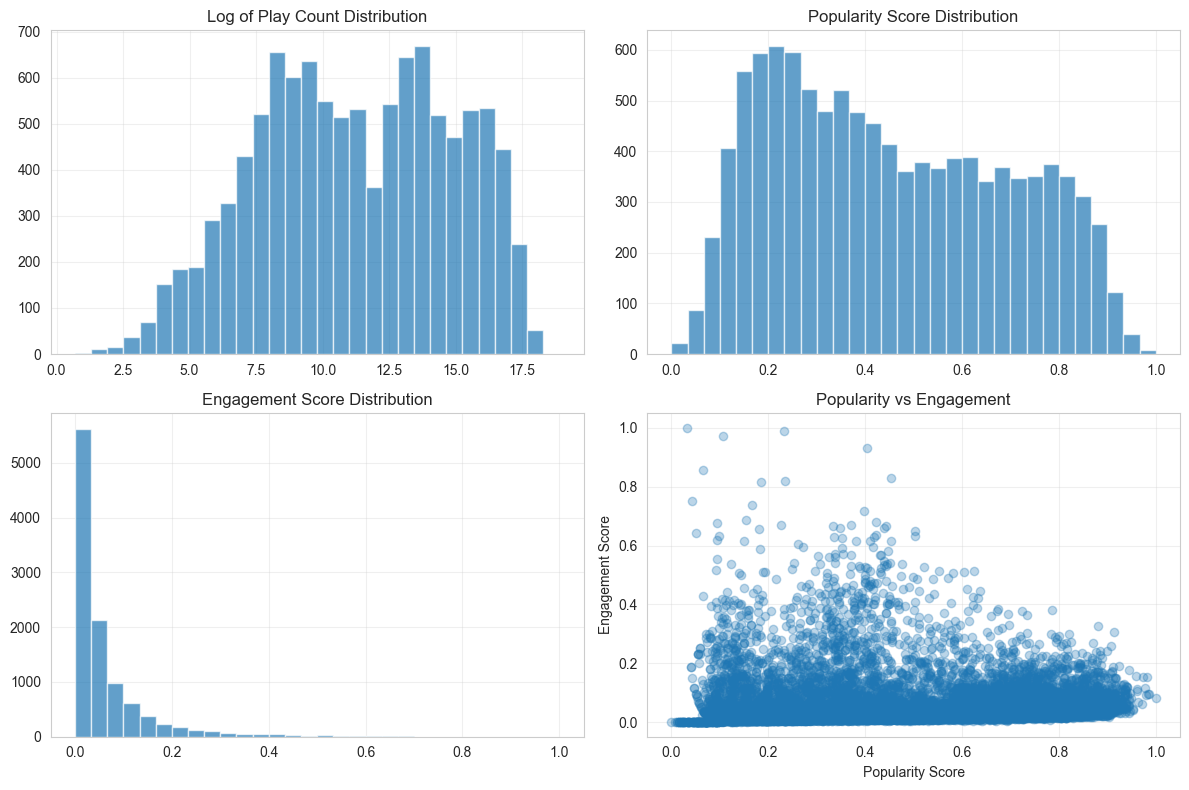

In [5]:
print("Creating video features...")

# Extract video metrics from item_daily_features
video_metrics = item_daily_features.groupby('video_id').agg({
    'video_duration': 'mean',
    'play_cnt': 'sum',
    'like_cnt': 'sum',
    'comment_cnt': 'sum',
    'share_cnt': 'sum',
    'follow_cnt': 'sum',
    'complete_play_cnt': 'sum',
    'valid_play_cnt': 'sum',
    'play_user_num': 'max',
    'like_user_num': 'max'
}).reset_index()

# Create engagement ratios
video_metrics['like_ratio'] = video_metrics['like_cnt'] / video_metrics['play_cnt'].clip(lower=1)
video_metrics['comment_ratio'] = video_metrics['comment_cnt'] / video_metrics['play_cnt'].clip(lower=1)
video_metrics['share_ratio'] = video_metrics['share_cnt'] / video_metrics['play_cnt'].clip(lower=1)
video_metrics['follow_ratio'] = video_metrics['follow_cnt'] / video_metrics['play_cnt'].clip(lower=1)
video_metrics['completion_ratio'] = video_metrics['complete_play_cnt'] / video_metrics['play_cnt'].clip(lower=1)
video_metrics['validity_ratio'] = video_metrics['valid_play_cnt'] / video_metrics['play_cnt'].clip(lower=1)

# Create aggregate popularity and engagement scores
# Use MinMaxScaler to scale the computed scores to [0, 1] range
video_metrics['popularity_score'] = MinMaxScaler().fit_transform(
    np.log1p(video_metrics[['play_cnt', 'like_cnt', 'comment_cnt', 'share_cnt']]).sum(axis=1).values.reshape(-1, 1)
)
video_metrics['engagement_score'] = MinMaxScaler().fit_transform(
    (video_metrics[['like_ratio', 'comment_ratio', 'share_ratio', 'follow_ratio']].mean(axis=1)).values.reshape(-1, 1)
)

print("Processing video categories...")

# Convert string representation of list to actual list
item_categories['feat'] = item_categories['feat'].apply(lambda x: json.loads(x.replace("'", '"')) if isinstance(x, str) else x)

# Create one-hot encoding for categories
category_features = pd.DataFrame(item_categories['video_id'])

# Get all unique categories
all_categories = set()
for categories in item_categories['feat']:
    if isinstance(categories, list):
        all_categories.update(categories)

print(f"Found {len(all_categories)} unique video categories")

# Initialize category columns with zeros
for category in all_categories:
    category_features[f'category_{category}'] = 0
    
# Fill in category values
for idx, row in item_categories.iterrows():
    if isinstance(row['feat'], list):
        for category in row['feat']:
            category_features.loc[idx, f'category_{category}'] = 1

# Extract content features from video captions using TF-IDF
print("Processing video captions with TF-IDF...")

caption_df = kuairec_caption[['video_id', 'caption']].dropna()
caption_df['caption'] = caption_df['caption'].astype(str)

# Create TF-IDF features from captions
tfidf = TfidfVectorizer(max_features=300)
tfidf_matrix = tfidf.fit_transform(caption_df['caption'])

tfidf_features_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=caption_df['video_id'].values,
    columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])]
).reset_index().rename(columns={'index': 'video_id'})

# Merge all video features
video_features = video_metrics.merge(category_features, on='video_id', how='left')
video_features = video_features.merge(tfidf_features_df, on='video_id', how='left')

video_features = video_features.fillna(0)

print(f"Created features for {len(video_features)} videos with {len(video_features.columns) - 1} features.")

# Visualize key video metrics
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.hist(np.log1p(video_features['play_cnt']), bins=30, alpha=0.7)
plt.title('Log of Play Count Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.hist(video_features['popularity_score'], bins=30, alpha=0.7)
plt.title('Popularity Score Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.hist(video_features['engagement_score'], bins=30, alpha=0.7)
plt.title('Engagement Score Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.scatter(video_features['popularity_score'], video_features['engagement_score'], alpha=0.3)
plt.title('Popularity vs Engagement')
plt.xlabel('Popularity Score')
plt.ylabel('Engagement Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### User-Video Interaction Matrix

In [6]:
print("Creating user-video interaction matrix...")

def create_interaction_matrix(data, user_col='user_id', item_col='video_id', rating_col='positive_interaction'):
    """
    Create a user-video interaction matrix.
    Returns a sparse matrix in CSR format.
    """
    # Create a mapping for user and video indices
    user_ids = data[user_col].unique()
    video_ids = data[item_col].unique()
    
    user_idx_map = {uid: i for i, uid in enumerate(user_ids)}
    video_idx_map = {vid: i for i, vid in enumerate(video_ids)}
    
    # Create indices for the sparse matrix
    user_indices = [user_idx_map[uid] for uid in data[user_col]]
    video_indices = [video_idx_map[vid] for vid in data[item_col]]
    
    # Create the sparse matrix
    ratings = data[rating_col].values
    interaction_matrix = csr_matrix((ratings, (user_indices, video_indices)), 
                                   shape=(len(user_ids), len(video_ids)))
    
    return interaction_matrix, user_ids, video_ids, user_idx_map, video_idx_map

# Create the interaction matrix for the training set
train_matrix, train_users, train_videos, user_map, video_map = create_interaction_matrix(train_data)
print(f"Sparse interaction matrix created: {train_matrix.shape}")
print(f"Matrix density: {train_matrix.count_nonzero() / (train_matrix.shape[0] * train_matrix.shape[1]):.6f}")

Creating user-video interaction matrix...
Sparse interaction matrix created: (7176, 10728)
Matrix density: 0.064341


In [7]:
print("Normalizing features for model training...")

# Identify numerical columns to normalize
user_num_cols = ['avg_watch_ratio', 'std_watch_ratio', 'interaction_count', 
                'avg_play_duration', 'total_play_duration', 'positive_interactions',
                'preferred_video_duration', 'video_duration_std',
                'follow_user_num', 'fans_user_num', 'friend_user_num', 'register_days']

video_num_cols = ['video_duration', 'play_cnt', 'like_cnt', 'comment_cnt', 'share_cnt',
                 'follow_cnt', 'complete_play_cnt', 'valid_play_cnt', 
                 'play_user_num', 'like_user_num',
                 'like_ratio', 'comment_ratio', 'share_ratio', 'follow_ratio',
                 'completion_ratio', 'validity_ratio']

# Create scalers
user_scaler = StandardScaler()
video_scaler = StandardScaler()

user_features_scaled = user_features_enriched.copy()
video_features_scaled = video_features.copy()

# Apply normalization to user features
user_features_scaled[user_num_cols] = user_scaler.fit_transform(
    user_features_enriched[user_num_cols].fillna(0))

# Apply normalization to video features
video_features_scaled[video_num_cols] = video_scaler.fit_transform(
    video_features[video_num_cols].fillna(0))

# Display sample of normalized features
print("Sample of normalized user features:")
display(user_features_scaled.head())

print("Sample of normalized video features:")
display(video_features_scaled.head())

Normalizing features for model training...
Sample of normalized user features:


,user_id,avg_watch_ratio,std_watch_ratio,interaction_count,avg_play_duration,total_play_duration,positive_interactions,preferred_video_duration,video_duration_std,user_active_degree,follow_user_num,fans_user_num,friend_user_num,register_days
0,0,0.834138,2.284655,0.773158,0.494428,1.103748,1.070739,-0.696228,-0.670306,high_active,-0.450930,-0.069352,-0.100120,-0.662766
1,1,-0.032647,-0.241998,-0.244222,0.190342,-0.149451,-0.303390,0.125832,0.293451,full_active,0.442359,-0.047253,-0.055571,0.105494
2,2,-1.440207,-0.587487,-0.687876,-1.068833,-0.945194,-0.995168,0.240493,-0.032275,full_active,-0.399349,-0.069352,-0.100120,-0.631338
3,3,-0.336274,-0.623679,1.723990,-0.476775,1.337937,1.738012,-0.109571,0.257315,full_active,-0.425140,-0.069352,-0.100120,-0.669751
4,4,-0.629293,-0.466363,-1.171863,0.630053,-1.055975,-1.059256,1.546971,0.885737,full_active,-0.176613,-0.047253,-0.100120,-0.250700


Sample of normalized video features:


,video_id,video_duration,play_cnt,like_cnt,comment_cnt,share_cnt,follow_cnt,complete_play_cnt,valid_play_cnt,play_user_num,like_user_num,like_ratio,comment_ratio,share_ratio,follow_ratio,completion_ratio,validity_ratio,popularity_score,engagement_score,category_0,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,category_11,category_12,category_13,category_14,category_15,category_16,category_17,category_18,category_19,category_20,category_21,category_22,category_23,category_24,category_25,category_26,category_27,category_28,category_29,category_30,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,tfidf_10,tfidf_11,tfidf_12,tfidf_13,tfidf_14,tfidf_15,tfidf_16,tfidf_17,tfidf_18,tfidf_19,tfidf_20,tfidf_21,tfidf_22,tfidf_23,tfidf_24,tfidf_25,tfidf_26,tfidf_27,tfidf_28,tfidf_29,tfidf_30,tfidf_31,tfidf_32,tfidf_33,tfidf_34,tfidf_35,tfidf_36,tfidf_37,tfidf_38,tfidf_39,tfidf_40,tfidf_41,tfidf_42,tfidf_43,tfidf_44,tfidf_45,tfidf_46,tfidf_47,tfidf_48,tfidf_49,tfidf_50,tfidf_51,tfidf_52,tfidf_53,tfidf_54,tfidf_55,tfidf_56,tfidf_57,tfidf_58,tfidf_59,tfidf_60,tfidf_61,tfidf_62,tfidf_63,tfidf_64,tfidf_65,tfidf_66,tfidf_67,tfidf_68,tfidf_69,tfidf_70,tfidf_71,tfidf_72,tfidf_73,tfidf_74,tfidf_75,tfidf_76,tfidf_77,tfidf_78,tfidf_79,tfidf_80,tfidf_81,tfidf_82,tfidf_83,tfidf_84,tfidf_85,tfidf_86,tfidf_87,tfidf_88,tfidf_89,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99,tfidf_100,tfidf_101,tfidf_102,tfidf_103,tfidf_104,tfidf_105,tfidf_106,tfidf_107,tfidf_108,tfidf_109,tfidf_110,tfidf_111,tfidf_112,tfidf_113,tfidf_114,tfidf_115,tfidf_116,tfidf_117,tfidf_118,tfidf_119,tfidf_120,tfidf_121,tfidf_122,tfidf_123,tfidf_124,tfidf_125,tfidf_126,tfidf_127,tfidf_128,tfidf_129,tfidf_130,tfidf_131,tfidf_132,tfidf_133,tfidf_134,tfidf_135,tfidf_136,tfidf_137,tfidf_138,tfidf_139,tfidf_140,tfidf_141,tfidf_142,tfidf_143,tfidf_144,tfidf_145,tfidf_146,tfidf_147,tfidf_148,tfidf_149,tfidf_150,tfidf_151,tfidf_152,tfidf_153,tfidf_154,tfidf_155,tfidf_156,tfidf_157,tfidf_158,tfidf_159,tfidf_160,tfidf_161,tfidf_162,tfidf_163,tfidf_164,tfidf_165,tfidf_166,tfidf_167,tfidf_168,tfidf_169,tfidf_170,tfidf_171,tfidf_172,tfidf_173,tfidf_174,tfidf_175,tfidf_176,tfidf_177,tfidf_178,tfidf_179,tfidf_180,tfidf_181,tfidf_182,tfidf_183,tfidf_184,tfidf_185,tfidf_186,tfidf_187,tfidf_188,tfidf_189,tfidf_190,tfidf_191,tfidf_192,tfidf_193,tfidf_194,tfidf_195,tfidf_196,tfidf_197,tfidf_198,tfidf_199,tfidf_200,tfidf_201,tfidf_202,tfidf_203,tfidf_204,tfidf_205,tfidf_206,tfidf_207,tfidf_208,tfidf_209,tfidf_210,tfidf_211,tfidf_212,tfidf_213,tfidf_214,tfidf_215,tfidf_216,tfidf_217,tfidf_218,tfidf_219,tfidf_220,tfidf_221,tfidf_222,tfidf_223,tfidf_224,tfidf_225,tfidf_226,tfidf_227,tfidf_228,tfidf_229,tfidf_230,tfidf_231,tfidf_232,tfidf_233,tfidf_234,tfidf_235,tfidf_236,tfidf_237,tfidf_238,tfidf_239,tfidf_240,tfidf_241,tfidf_242,tfidf_243,tfidf_244,tfidf_245,tfidf_246,tfidf_247,tfidf_248,tfidf_249,tfidf_250,tfidf_251,tfidf_252,tfidf_253,tfidf_254,tfidf_255,tfidf_256,tfidf_257,tfidf_258,tfidf_259,tfidf_260,tfidf_261,tfidf_262,tfidf_263,tfidf_264,tfidf_265,tfidf_266,tfidf_267,tfidf_268,tfidf_269,tfidf_270,tfidf_271,tfidf_272,tfidf_273,tfidf_274,tfidf_275,tfidf_276,tfidf_277,tfidf_278,tfidf_279,tfidf_280,tfidf_281,tfidf_282,tfidf_283,tfidf_284,tfidf_285,tfidf_286,tfidf_287,tfidf_288,tfidf_289,tfidf_290,tfidf_291,tfidf_292,tfidf_293,tfidf_294,tfidf_295,tfidf_296,tfidf_297,tfidf_298,tfidf_299
0,0,-0.411117,-0.334735,-0.250133,-0.203290,-0.135389,0.068725,-0.317067,-0.332375,-0.308010,-0.268808,0.467803,-0.169018,-0.144860,3.739356,0.653143,0.135822,0.594227,0.137258,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Save Features

In [8]:
os.makedirs('processed_data', exist_ok=True)

print("Saving processed features and matrices...")

# Save user and video features
user_features_scaled.to_csv('processed_data/user_features_processed.csv', index=False)
video_features_scaled.to_csv('processed_data/video_features_processed.csv', index=False)

# Save matrices and mappings for model training
interaction_data = {
    'train_matrix': train_matrix,
    'train_users': train_users,
    'train_videos': train_videos,
    'user_map': user_map,
    'video_map': video_map
}

with open('processed_data/interaction_matrix.pkl', 'wb') as f:
    pickle.dump(interaction_data, f)

scalers = {
    'user_scaler': user_scaler,
    'video_scaler': video_scaler
}

with open('processed_data/scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)

print("Feature engineering completed. Files saved to 'processed_data/' directory.")

Saving processed features and matrices...
Feature engineering completed. Files saved to 'processed_data/' directory.


### Feature Analysis

Correlation of user features with positive interactions:


positive_interactions       1.000000
interaction_count           0.864732
avg_watch_ratio             0.130971
fans_user_num              -0.002899
preferred_video_duration   -0.208102
dtype: float64

Correlation between key video features:


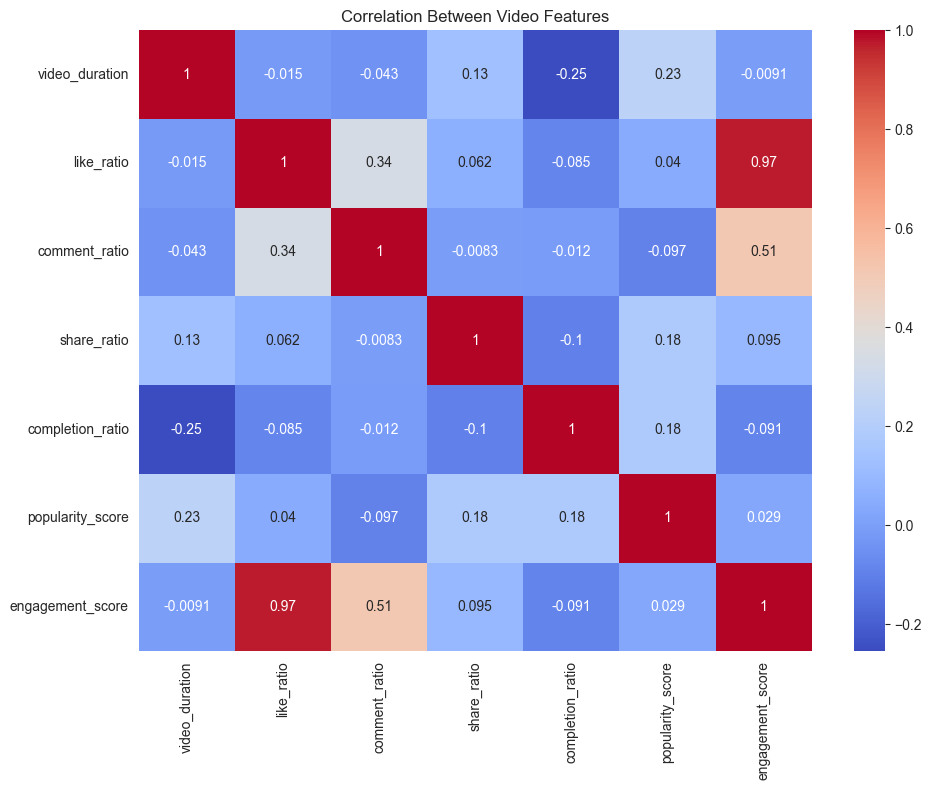

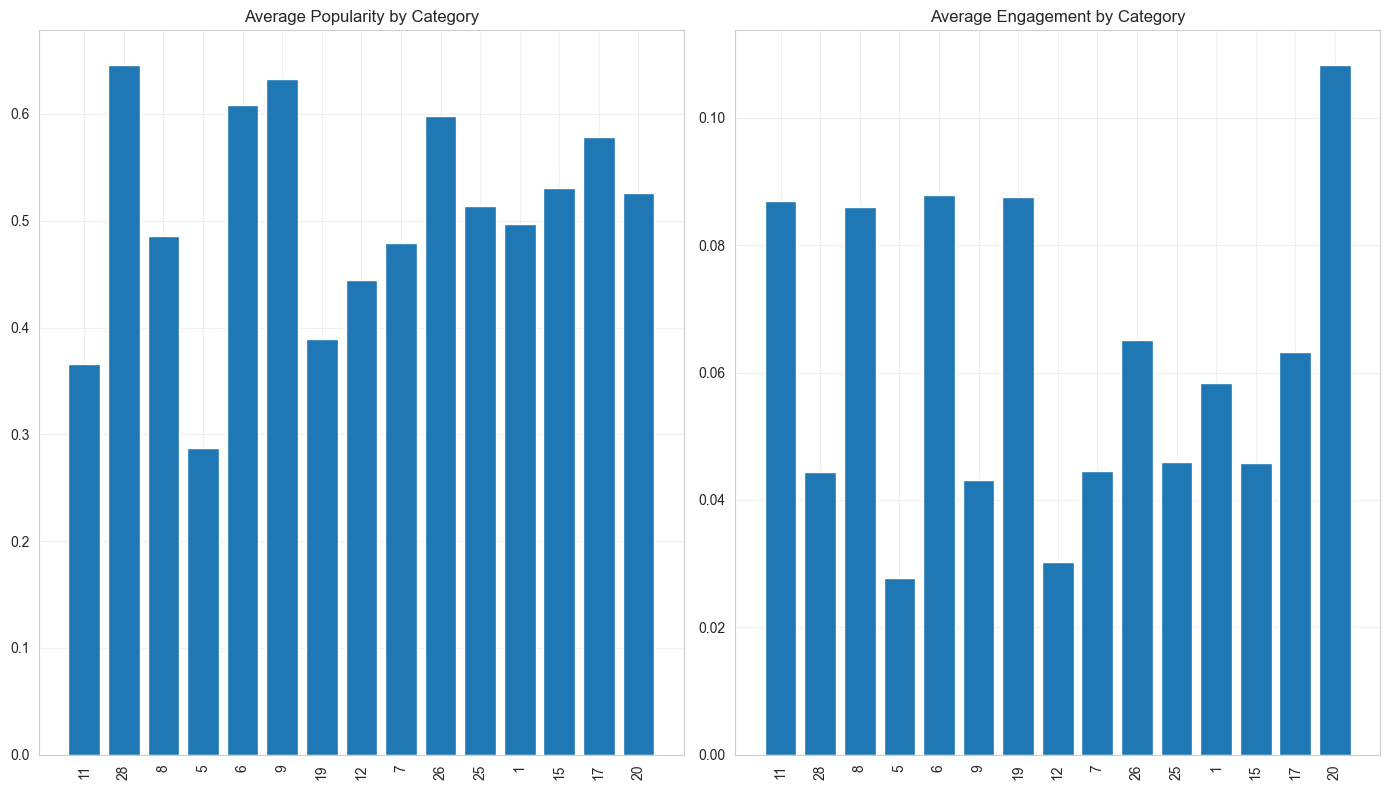

Feature engineering and analysis completed!


In [9]:
# Analyze how different features correlate with positive interactions
# Select key features from user and video datasets
selected_user_cols = ['avg_watch_ratio', 'interaction_count', 'positive_interactions', 
                      'preferred_video_duration', 'fans_user_num']  # Removed 'user_active_degree' (non-numeric)

# Get per-user averages of these features
user_avg_features = user_features_enriched[selected_user_cols]

# Correlation with interaction metrics
print("Correlation of user features with positive interactions:")
display(user_avg_features.corrwith(user_features_enriched['positive_interactions']).sort_values(ascending=False))

# Analyze video features impact on engagement
selected_video_cols = ['video_duration', 'like_ratio', 'comment_ratio', 'share_ratio', 
                      'completion_ratio', 'popularity_score', 'engagement_score']

# Correlation between video features
print("Correlation between key video features:")
video_features_corr = video_features[selected_video_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(video_features_corr, annot=True, cmap='coolwarm')
plt.title("Correlation Between Video Features")
plt.tight_layout()
plt.show()

# Category analysis
category_cols = [col for col in video_features.columns if col.startswith('category_')]
category_popularity = {}

for col in category_cols:
    # Calculate average popularity and engagement for videos in this category
    videos_in_category = video_features[video_features[col] == 1]
    if len(videos_in_category) > 0:
        category_popularity[col] = {
            'count': len(videos_in_category),
            'avg_popularity': videos_in_category['popularity_score'].mean(),
            'avg_engagement': videos_in_category['engagement_score'].mean()
        }

# Convert to DataFrame for easier visualization
category_stats = pd.DataFrame.from_dict(category_popularity, orient='index')
category_stats = category_stats.sort_values('count', ascending=False).head(15)  # Top 15 categories

# Plot category stats
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.bar(category_stats.index.str.replace('category_', ''), category_stats['avg_popularity'])
plt.title('Average Popularity by Category')
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(category_stats.index.str.replace('category_', ''), category_stats['avg_engagement'])
plt.title('Average Engagement by Category')
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Feature engineering and analysis completed!")